In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import time
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import convolve
from scipy import stats

import shap

In [2]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 23s, sys: 32.4 s, total: 2min 55s
Wall time: 2min 55s


In [3]:
# Split train data into Dataframe containing rows of 150000 data points.

rows = 150000
segments = int(np.floor(train.shape[0] / rows))
X_train = pd.DataFrame(index=range(4194), dtype=np.float64, columns = range(rows))
y_tr = pd.DataFrame(index=range(4194), dtype=np.float64, columns=range(1))

for segment in tqdm_notebook(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    X_train.iloc[segment] = seg['acoustic_data'].values
    y_tr.iloc[segment] = seg['time_to_failure'].values[-1]
    
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,149960,149961,149962,149963,149964,149965,149966,149967,149968,149969,149970,149971,149972,149973,149974,149975,149976,149977,149978,149979,149980,149981,149982,149983,149984,149985,149986,149987,149988,149989,149990,149991,149992,149993,149994,149995,149996,149997,149998,149999
0,12.0,6.0,8.0,5.0,8.0,8.0,9.0,7.0,-5.0,3.0,5.0,2.0,2.0,3.0,-1.0,5.0,6.0,4.0,3.0,5.0,4.0,2.0,6.0,7.0,7.0,8.0,14.0,9.0,4.0,7.0,4.0,3.0,4.0,8.0,6.0,4.0,11.0,9.0,4.0,3.0,...,3.0,5.0,3.0,5.0,5.0,0.0,0.0,5.0,0.0,2.0,6.0,7.0,9.0,5.0,5.0,5.0,7.0,5.0,11.0,10.0,8.0,7.0,4.0,3.0,7.0,7.0,10.0,10.0,5.0,6.0,13.0,7.0,4.0,7.0,-2.0,1.0,6.0,6.0,2.0,0.0
1,5.0,6.0,8.0,6.0,3.0,-1.0,5.0,4.0,4.0,4.0,6.0,5.0,5.0,5.0,6.0,4.0,8.0,7.0,3.0,7.0,9.0,5.0,7.0,6.0,6.0,3.0,0.0,4.0,8.0,8.0,6.0,4.0,3.0,1.0,5.0,5.0,4.0,5.0,-1.0,5.0,...,2.0,3.0,4.0,0.0,6.0,5.0,5.0,8.0,9.0,7.0,6.0,3.0,3.0,6.0,6.0,5.0,2.0,4.0,1.0,4.0,6.0,11.0,6.0,6.0,3.0,0.0,2.0,4.0,4.0,5.0,4.0,2.0,2.0,4.0,5.0,5.0,7.0,7.0,7.0,5.0
2,5.0,5.0,8.0,9.0,9.0,10.0,11.0,12.0,13.0,5.0,3.0,7.0,5.0,3.0,1.0,4.0,3.0,5.0,5.0,4.0,4.0,-2.0,-1.0,5.0,7.0,3.0,5.0,8.0,8.0,8.0,6.0,8.0,7.0,4.0,10.0,5.0,-1.0,2.0,1.0,2.0,...,9.0,6.0,7.0,13.0,14.0,11.0,8.0,4.0,8.0,4.0,6.0,1.0,6.0,6.0,3.0,-3.0,2.0,0.0,3.0,10.0,6.0,8.0,12.0,9.0,6.0,0.0,3.0,2.0,5.0,2.0,4.0,7.0,9.0,8.0,13.0,15.0,6.0,5.0,8.0,3.0
3,5.0,-5.0,-4.0,1.0,3.0,4.0,6.0,12.0,15.0,17.0,14.0,9.0,6.0,6.0,3.0,3.0,3.0,4.0,6.0,3.0,2.0,5.0,2.0,7.0,7.0,7.0,4.0,6.0,10.0,11.0,8.0,2.0,5.0,6.0,4.0,6.0,6.0,4.0,0.0,-1.0,...,4.0,7.0,9.0,5.0,4.0,7.0,6.0,6.0,3.0,2.0,6.0,10.0,6.0,5.0,2.0,0.0,3.0,4.0,4.0,2.0,6.0,9.0,3.0,4.0,7.0,9.0,9.0,6.0,3.0,4.0,6.0,6.0,6.0,3.0,10.0,11.0,7.0,3.0,8.0,5.0
4,12.0,6.0,4.0,-1.0,0.0,6.0,7.0,6.0,2.0,-2.0,0.0,4.0,1.0,5.0,6.0,9.0,8.0,1.0,4.0,8.0,11.0,10.0,3.0,-1.0,0.0,3.0,5.0,1.0,0.0,3.0,8.0,6.0,8.0,13.0,11.0,7.0,7.0,9.0,2.0,2.0,...,3.0,8.0,5.0,2.0,5.0,6.0,0.0,2.0,0.0,3.0,6.0,8.0,7.0,8.0,9.0,7.0,6.0,6.0,4.0,6.0,6.0,3.0,4.0,5.0,0.0,3.0,6.0,2.0,7.0,1.0,3.0,0.0,-4.0,-1.0,2.0,3.0,0.0,6.0,5.0,11.0


In [4]:
y_tr.head()

,0
0,1.430797219276428
1,1.391498923301697
2,1.353196144104004
3,1.313797831535339
4,1.274399518966675


In [5]:
# Dataframe to create features from test data

X_tr = pd.DataFrame(index=range(4194), dtype=np.float64)

for segment in tqdm_notebook(X_train.index):
    X_tr.loc[segment, 'mean'] = X_train.loc[segment].mean()
    X_tr.loc[segment,'max'] = X_train.loc[segment].max()
    X_tr.loc[segment,'min'] = X_train.loc[segment].min()
    X_tr.loc[segment, 'std'] = X_train.loc[segment].std()
    X_tr.loc[segment, 'var'] = X_train.loc[segment].var()
    X_tr.loc[segment, 'kurt'] = X_train.loc[segment].kurtosis()
    X_tr.loc[segment, 'skew'] = X_train.loc[segment].skew()
    X_tr.loc[segment, 'med'] = X_train.loc[segment].median()
    X_tr.loc[segment, 'sum'] = X_train.loc[segment].sum()
    X_tr.loc[segment, 'q91'] = np.quantile(X_train.loc[segment], 0.91)
    X_tr.loc[segment, 'q92'] = np.quantile(X_train.loc[segment], 0.92)
    X_tr.loc[segment, 'q93'] = np.quantile(X_train.loc[segment], 0.93)
    X_tr.loc[segment, 'q94'] = np.quantile(X_train.loc[segment], 0.94)
    X_tr.loc[segment, 'q95'] = np.quantile(X_train.loc[segment], 0.95)
    X_tr.loc[segment, 'q96'] = np.quantile(X_train.loc[segment], 0.96)
    X_tr.loc[segment, 'q97'] = np.quantile(X_train.loc[segment], 0.97)
    X_tr.loc[segment, 'q98'] = np.quantile(X_train.loc[segment], 0.98)
    X_tr.loc[segment, 'q99'] = np.quantile(X_train.loc[segment], 0.99)
    X_tr.loc[segment, 'q01'] = np.quantile(X_train.loc[segment], 0.01)
    X_tr.loc[segment, 'q02'] = np.quantile(X_train.loc[segment], 0.02)
    X_tr.loc[segment, 'q03'] = np.quantile(X_train.loc[segment], 0.03)
    X_tr.loc[segment, 'q04'] = np.quantile(X_train.loc[segment], 0.04)
    X_tr.loc[segment, 'q05'] = np.quantile(X_train.loc[segment], 0.05)
    X_tr.loc[segment, 'q06'] = np.quantile(X_train.loc[segment], 0.06)
    X_tr.loc[segment, 'q07'] = np.quantile(X_train.loc[segment], 0.07)
    X_tr.loc[segment, 'q08'] = np.quantile(X_train.loc[segment], 0.08)
    X_tr.loc[segment, 'q09'] = np.quantile(X_train.loc[segment], 0.09)
    X_tr.loc[segment, 'q999'] = np.quantile(X_train.loc[segment],0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(X_train.loc[segment],0.001)

    
X_tr.head(10)


In [6]:
X_tr.shape

(4194, 29)

In [7]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

In [8]:
# Reading test files into a dataframe,
# with rows as file names and columns as the acoustic signal data. 

submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X = pd.DataFrame(columns=range(0,150000), dtype=np.float64, index=submission.index)

for seg_id in tqdm_notebook(X.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    X.loc[seg_id,] = seg['acoustic_data'].values

X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,149960,149961,149962,149963,149964,149965,149966,149967,149968,149969,149970,149971,149972,149973,149974,149975,149976,149977,149978,149979,149980,149981,149982,149983,149984,149985,149986,149987,149988,149989,149990,149991,149992,149993,149994,149995,149996,149997,149998,149999
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,4.0,0.0,-2.0,0.0,2.0,-3.0,-9.0,-4.0,11.0,11.0,8.0,1.0,10.0,9.0,12.0,13.0,11.0,11.0,7.0,5.0,2.0,0.0,2.0,-2.0,0.0,4.0,4.0,2.0,4.0,8.0,9.0,9.0,12.0,9.0,5.0,9.0,2.0,0.0,-3.0,1.0,...,8.0,5.0,-2.0,2.0,6.0,9.0,5.0,3.0,4.0,3.0,4.0,5.0,5.0,2.0,2.0,0.0,2.0,3.0,6.0,5.0,7.0,9.0,9.0,7.0,7.0,8.0,7.0,6.0,4.0,5.0,8.0,6.0,2.0,0.0,-3.0,2.0,0.0,6.0,9.0,8.0
seg_0012b5,5.0,8.0,8.0,7.0,4.0,1.0,-1.0,-4.0,-1.0,0.0,5.0,7.0,-1.0,7.0,11.0,8.0,2.0,1.0,2.0,5.0,-2.0,2.0,7.0,4.0,6.0,3.0,4.0,2.0,10.0,7.0,3.0,2.0,-3.0,-3.0,-5.0,-2.0,0.0,6.0,9.0,11.0,...,3.0,5.0,8.0,6.0,3.0,3.0,1.0,0.0,3.0,6.0,5.0,7.0,4.0,3.0,3.0,8.0,5.0,4.0,2.0,1.0,4.0,8.0,2.0,-2.0,1.0,0.0,6.0,0.0,6.0,3.0,4.0,3.0,3.0,1.0,6.0,7.0,2.0,2.0,1.0,3.0
seg_00184e,8.0,2.0,3.0,8.0,7.0,9.0,7.0,4.0,4.0,9.0,9.0,1.0,2.0,6.0,4.0,10.0,7.0,6.0,7.0,8.0,6.0,0.0,2.0,4.0,5.0,4.0,3.0,1.0,2.0,-2.0,-1.0,4.0,8.0,6.0,-1.0,0.0,2.0,5.0,-2.0,2.0,...,6.0,7.0,8.0,5.0,5.0,4.0,7.0,9.0,10.0,9.0,5.0,4.0,7.0,5.0,1.0,-4.0,-2.0,1.0,5.0,7.0,10.0,6.0,6.0,5.0,3.0,4.0,4.0,2.0,3.0,1.0,2.0,3.0,-1.0,0.0,8.0,10.0,4.0,-1.0,2.0,5.0
seg_003339,2.0,6.0,3.0,6.0,8.0,6.0,8.0,5.0,4.0,6.0,2.0,3.0,1.0,4.0,6.0,4.0,4.0,8.0,2.0,4.0,3.0,4.0,5.0,6.0,4.0,4.0,4.0,2.0,2.0,1.0,6.0,5.0,1.0,3.0,7.0,12.0,5.0,3.0,5.0,7.0,...,4.0,5.0,4.0,5.0,3.0,6.0,3.0,0.0,3.0,6.0,4.0,3.0,2.0,4.0,5.0,3.0,6.0,4.0,3.0,3.0,-1.0,2.0,1.0,5.0,6.0,6.0,3.0,4.0,6.0,7.0,7.0,5.0,3.0,0.0,6.0,10.0,8.0,2.0,-2.0,9.0
seg_0042cc,5.0,3.0,1.0,4.0,6.0,6.0,7.0,4.0,5.0,4.0,3.0,4.0,6.0,7.0,3.0,7.0,2.0,2.0,3.0,4.0,4.0,0.0,2.0,5.0,9.0,5.0,1.0,5.0,8.0,8.0,7.0,5.0,3.0,3.0,1.0,1.0,3.0,4.0,7.0,7.0,...,6.0,5.0,9.0,2.0,-1.0,7.0,7.0,6.0,3.0,3.0,9.0,9.0,5.0,4.0,8.0,4.0,6.0,3.0,3.0,6.0,5.0,5.0,7.0,5.0,5.0,6.0,6.0,9.0,6.0,8.0,5.0,6.0,1.0,-2.0,4.0,8.0,2.0,2.0,5.0,4.0


In [9]:
# Remove index name seg_id
del X.index.name
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,149960,149961,149962,149963,149964,149965,149966,149967,149968,149969,149970,149971,149972,149973,149974,149975,149976,149977,149978,149979,149980,149981,149982,149983,149984,149985,149986,149987,149988,149989,149990,149991,149992,149993,149994,149995,149996,149997,149998,149999
seg_00030f,4.0,0.0,-2.0,0.0,2.0,-3.0,-9.0,-4.0,11.0,11.0,8.0,1.0,10.0,9.0,12.0,13.0,11.0,11.0,7.0,5.0,2.0,0.0,2.0,-2.0,0.0,4.0,4.0,2.0,4.0,8.0,9.0,9.0,12.0,9.0,5.0,9.0,2.0,0.0,-3.0,1.0,...,8.0,5.0,-2.0,2.0,6.0,9.0,5.0,3.0,4.0,3.0,4.0,5.0,5.0,2.0,2.0,0.0,2.0,3.0,6.0,5.0,7.0,9.0,9.0,7.0,7.0,8.0,7.0,6.0,4.0,5.0,8.0,6.0,2.0,0.0,-3.0,2.0,0.0,6.0,9.0,8.0
seg_0012b5,5.0,8.0,8.0,7.0,4.0,1.0,-1.0,-4.0,-1.0,0.0,5.0,7.0,-1.0,7.0,11.0,8.0,2.0,1.0,2.0,5.0,-2.0,2.0,7.0,4.0,6.0,3.0,4.0,2.0,10.0,7.0,3.0,2.0,-3.0,-3.0,-5.0,-2.0,0.0,6.0,9.0,11.0,...,3.0,5.0,8.0,6.0,3.0,3.0,1.0,0.0,3.0,6.0,5.0,7.0,4.0,3.0,3.0,8.0,5.0,4.0,2.0,1.0,4.0,8.0,2.0,-2.0,1.0,0.0,6.0,0.0,6.0,3.0,4.0,3.0,3.0,1.0,6.0,7.0,2.0,2.0,1.0,3.0
seg_00184e,8.0,2.0,3.0,8.0,7.0,9.0,7.0,4.0,4.0,9.0,9.0,1.0,2.0,6.0,4.0,10.0,7.0,6.0,7.0,8.0,6.0,0.0,2.0,4.0,5.0,4.0,3.0,1.0,2.0,-2.0,-1.0,4.0,8.0,6.0,-1.0,0.0,2.0,5.0,-2.0,2.0,...,6.0,7.0,8.0,5.0,5.0,4.0,7.0,9.0,10.0,9.0,5.0,4.0,7.0,5.0,1.0,-4.0,-2.0,1.0,5.0,7.0,10.0,6.0,6.0,5.0,3.0,4.0,4.0,2.0,3.0,1.0,2.0,3.0,-1.0,0.0,8.0,10.0,4.0,-1.0,2.0,5.0
seg_003339,2.0,6.0,3.0,6.0,8.0,6.0,8.0,5.0,4.0,6.0,2.0,3.0,1.0,4.0,6.0,4.0,4.0,8.0,2.0,4.0,3.0,4.0,5.0,6.0,4.0,4.0,4.0,2.0,2.0,1.0,6.0,5.0,1.0,3.0,7.0,12.0,5.0,3.0,5.0,7.0,...,4.0,5.0,4.0,5.0,3.0,6.0,3.0,0.0,3.0,6.0,4.0,3.0,2.0,4.0,5.0,3.0,6.0,4.0,3.0,3.0,-1.0,2.0,1.0,5.0,6.0,6.0,3.0,4.0,6.0,7.0,7.0,5.0,3.0,0.0,6.0,10.0,8.0,2.0,-2.0,9.0
seg_0042cc,5.0,3.0,1.0,4.0,6.0,6.0,7.0,4.0,5.0,4.0,3.0,4.0,6.0,7.0,3.0,7.0,2.0,2.0,3.0,4.0,4.0,0.0,2.0,5.0,9.0,5.0,1.0,5.0,8.0,8.0,7.0,5.0,3.0,3.0,1.0,1.0,3.0,4.0,7.0,7.0,...,6.0,5.0,9.0,2.0,-1.0,7.0,7.0,6.0,3.0,3.0,9.0,9.0,5.0,4.0,8.0,4.0,6.0,3.0,3.0,6.0,5.0,5.0,7.0,5.0,5.0,6.0,6.0,9.0,6.0,8.0,5.0,6.0,1.0,-2.0,4.0,8.0,2.0,2.0,5.0,4.0


In [10]:
X_test = pd.DataFrame(index=X.index, dtype=np.float64)

for row in tqdm_notebook(X.index):
    X_test.loc[row, 'mean'] = X.loc[row].mean()
    X_test.loc[row,'max'] = X.loc[row].max()
    X_test.loc[row,'min'] = X.loc[row].min()
    X_test.loc[row, 'std'] = X.loc[row].std()
    X_test.loc[row, 'var'] = X.loc[row].var()
    X_test.loc[row, 'kurt'] = X.loc[row].kurtosis()
    X_test.loc[row, 'skew'] = X.loc[row].skew()
    X_test.loc[row, 'med'] = X.loc[row].median()
    X_test.loc[row, 'sum'] = X.loc[row].sum()
    X_test.loc[row, 'q91'] = np.quantile(X.loc[row], 0.91)
    X_test.loc[row, 'q92'] = np.quantile(X.loc[row], 0.92)
    X_test.loc[row, 'q93'] = np.quantile(X.loc[row], 0.93)
    X_test.loc[row, 'q94'] = np.quantile(X.loc[row], 0.94)
    X_test.loc[row, 'q95'] = np.quantile(X.loc[row], 0.95)
    X_test.loc[row, 'q96'] = np.quantile(X.loc[row], 0.96)
    X_test.loc[row, 'q97'] = np.quantile(X.loc[row], 0.97)
    X_test.loc[row, 'q98'] = np.quantile(X.loc[row], 0.98)
    X_test.loc[row, 'q99'] = np.quantile(X.loc[row], 0.99)
    X_test.loc[row, 'q01'] = np.quantile(X.loc[row], 0.01)
    X_test.loc[row, 'q02'] = np.quantile(X.loc[row], 0.02)
    X_test.loc[row, 'q03'] = np.quantile(X.loc[row], 0.03)
    X_test.loc[row, 'q04'] = np.quantile(X.loc[row], 0.04)
    X_test.loc[row, 'q05'] = np.quantile(X.loc[row], 0.05)
    X_test.loc[row, 'q06'] = np.quantile(X.loc[row], 0.06)
    X_test.loc[row, 'q07'] = np.quantile(X.loc[row], 0.07)
    X_test.loc[row, 'q08'] = np.quantile(X.loc[row], 0.08)
    X_test.loc[row, 'q09'] = np.quantile(X.loc[row], 0.09)
    X_test.loc[row, 'q999'] = np.quantile(X.loc[row],0.999)
    X_test.loc[row, 'q001'] = np.quantile(X.loc[row],0.001)

X_test.head()

,mean,max,min,std,var,kurt,skew,med,sum,q91,q92,q93,q94,q95,q96,q97,q98,q99,q01,q02,q03,q04,q05,q06,q07,q08,q09,q999,q001
seg_00030f,4.491780000000000,115.0,-75.0,4.893689687028069,23.948198752924885,28.837568099164539,0.327907635264522,4.0,673767.0,10.0,10.0,10.0,11.0,11.0,12.0,13.0,14.0,18.0,-8.0,-5.0,-3.0,-3.0,-2.0,-2.0,-1.0,-1.0,0.0,34.0,-26.0
seg_0012b5,4.171153333333334,152.0,-140.0,5.922839443206628,35.080027070004199,56.218954550493322,0.295707859154105,4.0,625673.0,9.0,9.0,10.0,10.0,11.0,12.0,13.0,15.0,20.0,-12.0,-6.0,-4.0,-3.0,-2.0,-2.0,-1.0,-1.0,-1.0,48.0,-42.0
seg_00184e,4.610260000000000,248.0,-193.0,6.946990077490285,48.260671136748478,162.118283628401656,0.428688288294736,5.0,691539.0,9.0,10.0,10.0,11.0,11.0,12.0,13.0,15.0,20.0,-11.0,-6.0,-4.0,-2.0,-2.0,-1.0,-1.0,-1.0,0.0,65.0,-57.0
seg_003339,4.531473333333333,85.0,-93.0,4.114146602958288,16.926202270633226,41.241827462130018,0.061889362911379,5.0,679721.0,9.0,9.0,9.0,9.0,10.0,10.0,11.0,12.0,14.0,-5.0,-3.0,-2.0,-1.0,-1.0,0.0,0.0,0.0,0.0,35.0,-24.0
seg_0042cc,4.128340000000000,177.0,-147.0,5.797163636220498,33.607106225117263,79.539707613111105,0.073898350757301,4.0,619251.0,9.0,9.0,10.0,10.0,10.0,11.0,12.0,14.0,19.0,-10.0,-6.0,-4.0,-3.0,-2.0,-2.0,-1.0,-1.0,-1.0,50.0,-42.0


In [11]:
X_test.shape

(2624, 29)

In [12]:
scaler = StandardScaler()
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [13]:
# RF regressor model

from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, max_depth = 100, min_samples_leaf = 30, min_samples_split = 30)
forest.fit(X_train_scaled.values, y_tr.values)

#print(regr_lanl.feature_importances_)

prediction_rf = forest.predict(X_test_scaled.values)

submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_rf
print(submission.head())
submission.to_csv('submission_rf.csv')

              time_to_failure
seg_id                       
seg_00030f  4.318876942030558
seg_0012b5  5.107330939275591
seg_00184e  5.857186481888395
seg_003339  8.789140493561137
seg_0042cc  7.338860203828507


In [14]:
# print the JS visualization code to the notebook
shap.initjs()

#X1,y = shap.datasets.adult()
#X_display,y_display = shap.datasets.adult(display=True)

In [15]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_train_scaled)

In [16]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_scaled.iloc[0,:])

In [17]:
shap.force_plot(explainer.expected_value, shap_values[4,:], X_train_scaled.iloc[4,:])


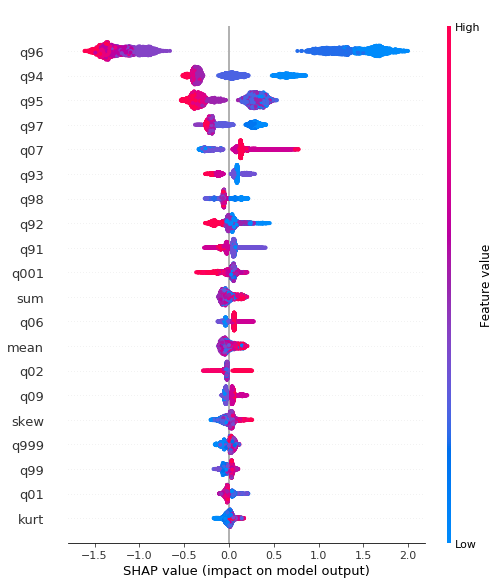

In [18]:
shap.summary_plot(shap_values,X_train_scaled)

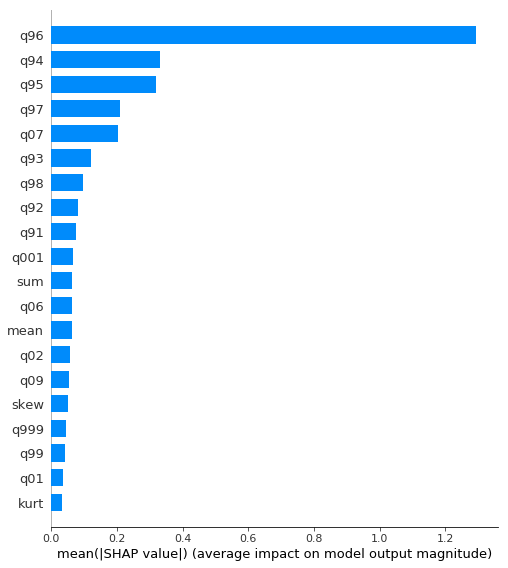

In [19]:
shap.summary_plot(shap_values, X_train_scaled, plot_type="bar")

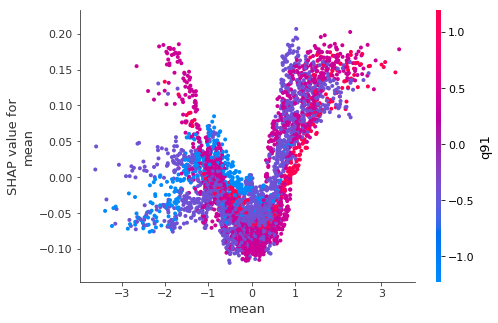

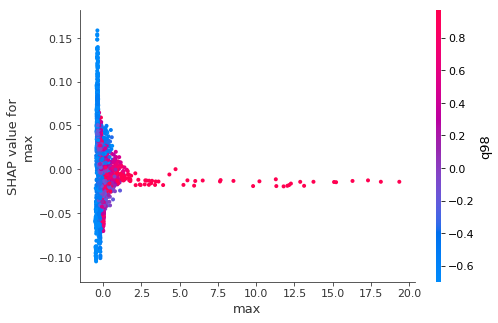

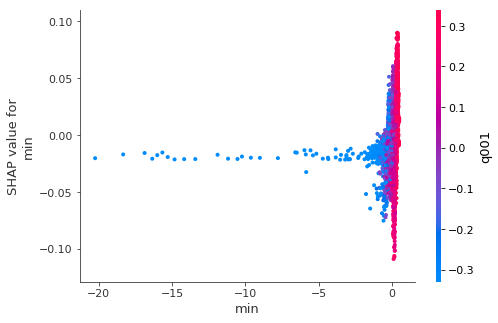

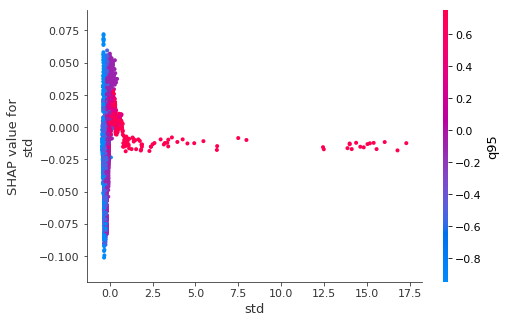

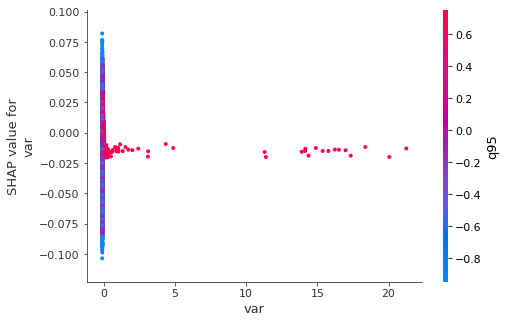

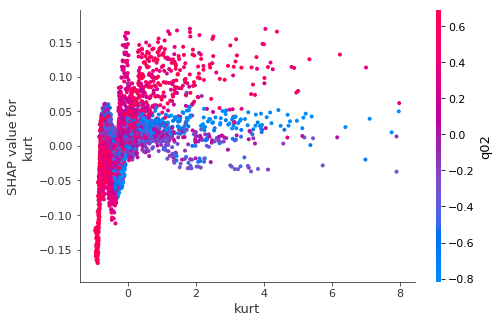

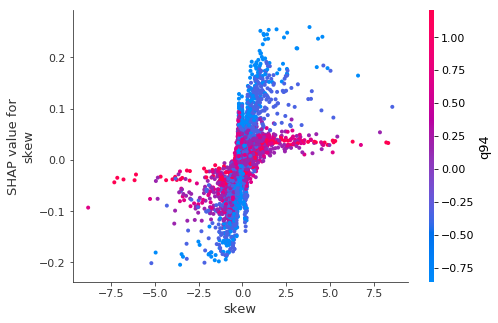

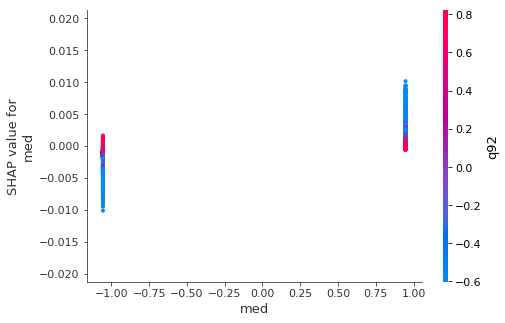

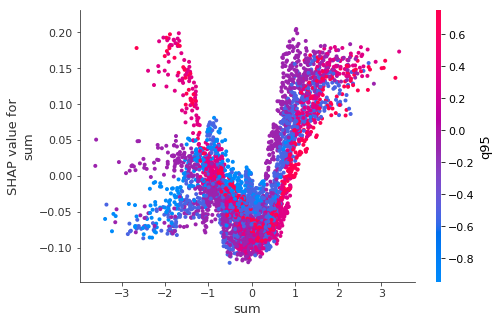

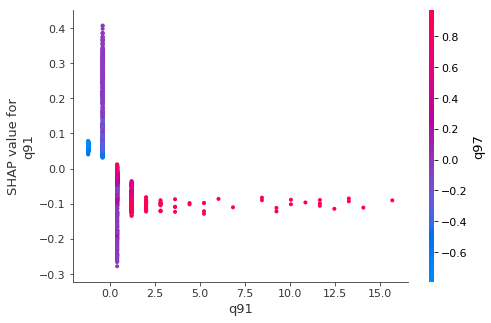

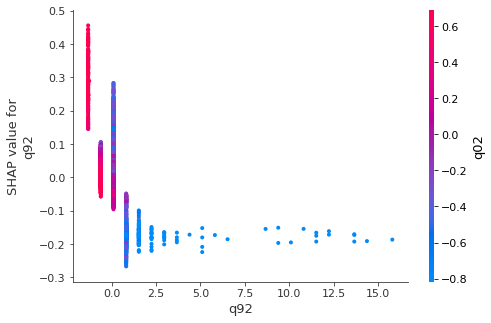

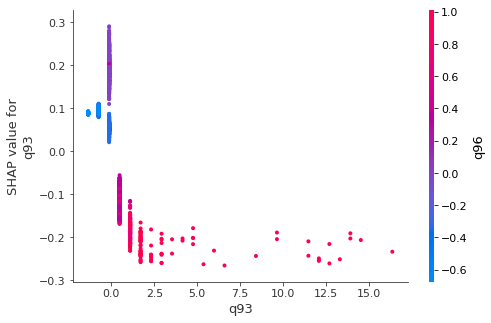

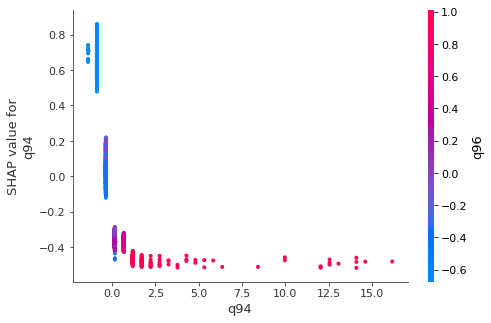

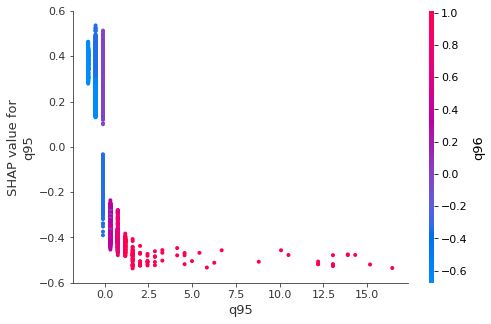

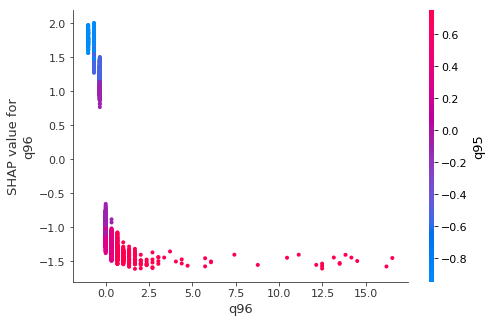

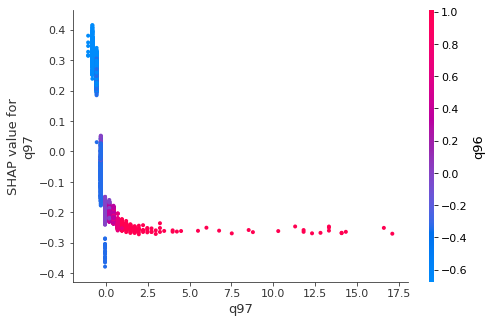

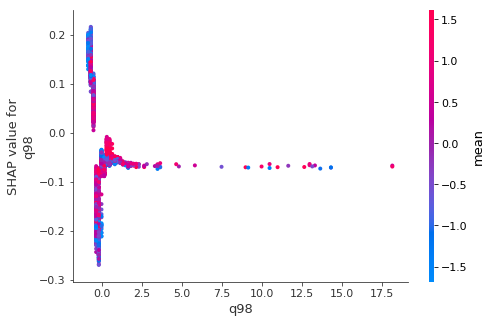

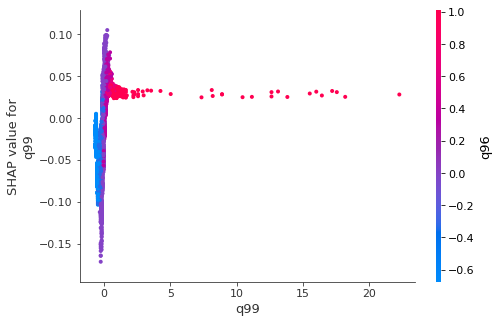

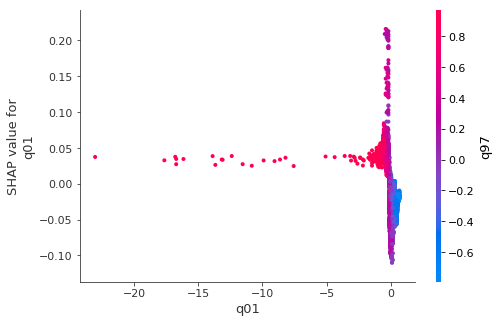

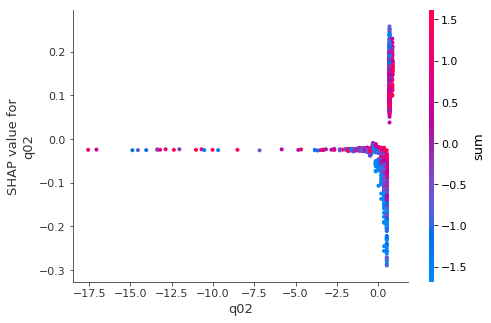

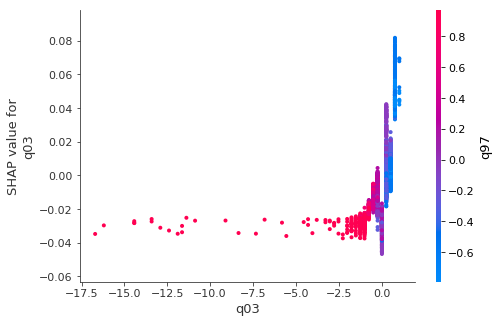

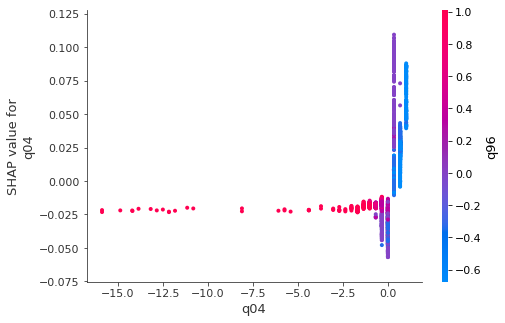

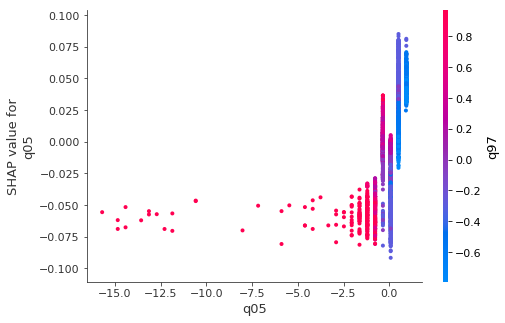

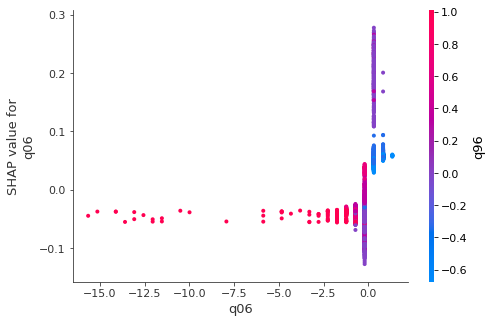

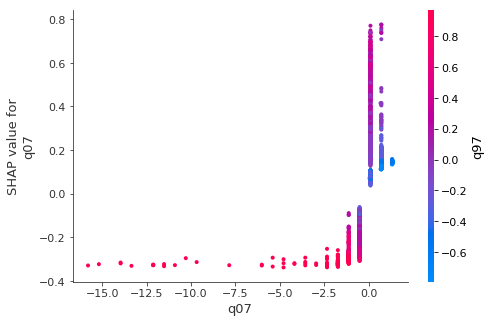

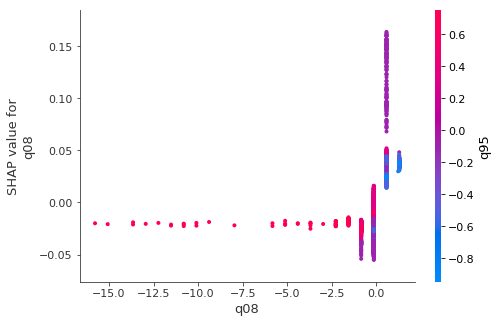

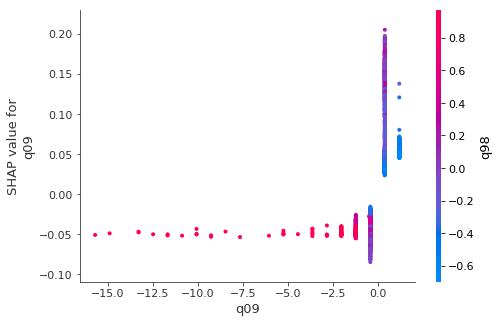

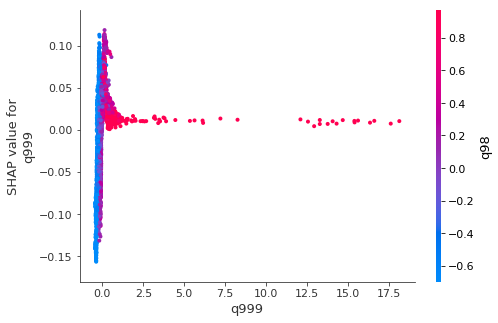

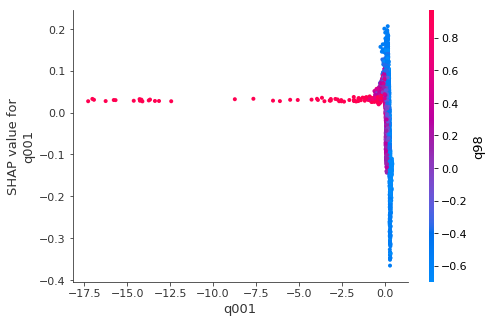

In [20]:
for name in X_tr.columns:
    shap.dependence_plot(name, shap_values, X_train_scaled)